# Application of Monte Carlo Simulations to Calculate VaR

#### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

C:\Users\princ\AppData\Local\Temp\ipykernel_3052\1271272703.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Setting Time Range and Ticker List

In [ ]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365*years)


tickers = ['SPY','BND','GLD','QQQ','VTI']

#### Downloading Adjusted Close Prices

In [ ]:
adjusted_cp_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adjusted_cp_df[ticker] = data['Adj Close']

print(adjusted_cp_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2009-03-06   51.787926  49.502071   92.290001   22.981503   25.791931
2009-03-09   51.179276  49.320179   90.570000   22.492159   25.481903
2009-03-10   54.230045  49.372143   88.139999   23.881533   27.107609
2009-03-11   54.583195  49.476112   89.220001   24.248545   27.205910
2009-03-12   56.732292  49.586559   91.099998   25.052464   28.325001
...                ...        ...         ...         ...         ...
2024-02-26  505.989990  71.848480  188.199997  436.549988  251.240005
2024-02-27  506.929993  71.738785  188.000000  437.600006  251.940002
2024-02-28  506.260010  71.898331  188.339996  435.269989  251.520004
2024-02-29  508.079987  72.017998  189.309998  439.000000  252.580002
2024-03-01  512.849976  72.320000  192.889999  445.609985  254.899994

[3773 rows x 5 columns]


#### Calculating Daily Log retuns

In [ ]:
daily_log = np.log(adjusted_cp_df/adjusted_cp_df.shift(1))
daily_log  = daily_log.dropna()

print(daily_log)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2009-03-09 -0.011822 -0.003681 -0.018813 -0.021523 -0.012093
2009-03-10  0.057900  0.001053 -0.027197  0.059939  0.061846
2009-03-11  0.006491  0.002104  0.012179  0.015251  0.003620
2009-03-12  0.038618  0.002230  0.020853  0.032616  0.040311
2009-03-13  0.007784 -0.000787  0.002193  0.002438  0.010621
...              ...       ...       ...       ...       ...
2024-02-26 -0.003669 -0.001803 -0.002229 -0.000527 -0.003020
2024-02-27  0.001856 -0.001528 -0.001063  0.002402  0.002782
2024-02-28 -0.001323  0.002222  0.001807 -0.005339 -0.001668
2024-02-29  0.003588  0.001663  0.005137  0.008533  0.004206
2024-03-01  0.009344  0.004185  0.018734  0.014945  0.009143

[3772 rows x 5 columns]


#### Functions For Calculating Portfolio Returns and Expected Deviation

In [ ]:
def return_expected(weights, daily_log):
    return np.sum(daily_log.mean()*weights)


def calculate_sd (weights, cv_matrix):
    variance = weights.T @ cv_matrix @ weights
    return np.sqrt(variance)

#### Creating a Covariance Matrix

In [ ]:
cv_matrix = daily_log.cov()
print(cv_matrix)

              SPY           BND       GLD           QQQ           VTI
SPY  1.244105e-04 -3.948832e-07  0.000006  1.347973e-04  1.270218e-04
BND -3.948832e-07  9.245981e-06  0.000009  4.885527e-07 -2.160260e-07
GLD  6.384992e-06  8.917798e-06  0.000098  6.844613e-06  6.887696e-06
QQQ  1.347973e-04  4.885527e-07  0.000007  1.702644e-04  1.379197e-04
VTI  1.270218e-04 -2.160260e-07  0.000007  1.379197e-04  1.307833e-04


#### Calculating Portfolio Expected Return and Standard Deviation

In [ ]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_return_expected = return_expected(weights, daily_log)
portfolio_sd = calculate_sd (weights, cv_matrix)

#### Defining Functions for Monte Carlo Simulation

In [ ]:
def random_z_score():
    return np.random.normal(0, 1) # mu=0 , sigma =1

### Function to calculate scenarioGainLoss
days = 20

def scenario_gain_loss(portfolio_value, portfolio_sd, z_score, days):
    return portfolio_value * portfolio_return_expected * days + portfolio_value * portfolio_sd * z_score * np.sqrt(days)

#### Running Monte Carlo Simulation

In [ ]:
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_sd, z_score, days))

#### Calculating Value at Risk (VaR)

In [ ]:
confidence_interval = 0.99
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

68667.18569730023


#### Plotting the Results

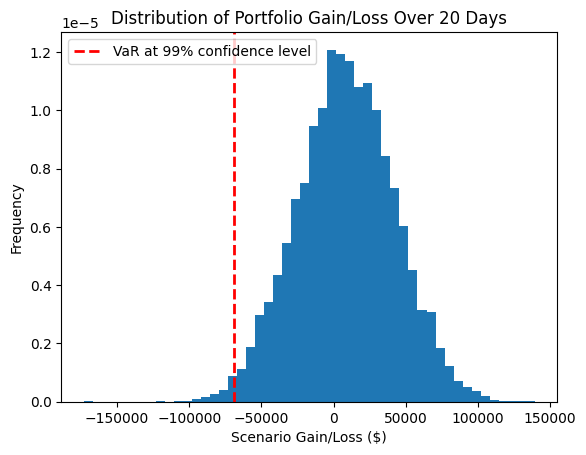

In [ ]:
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss Over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()